In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
glfsr = np.fromfile('/tmp/glfrs.u8', dtype = 'uint8')
recv_bits = np.fromfile('/tmp/recv_bits.u8', dtype = 'uint8')
recv_symbols_diff = np.fromfile('/tmp/recv_symbols_diff.c64', dtype = 'complex64')

In [3]:
corr = scipy.signal.correlate(2*glfsr.astype('int')-1, 2*recv_bits.astype('int')-1)

In [4]:
bit_errors = recv_bits ^ np.tile(glfsr, 3)[glfsr.size-1932:][:recv_bits.size]
np.sum(bit_errors)

15668

In [5]:
navg = 100
w = np.where(np.average(bit_errors[:bit_errors.size//navg*navg].reshape((-1,navg)), axis = 1) < 0.1)[0]
a = w[0]+1
b = w[-1]-1
sel = slice(a*navg, b*navg)

In [6]:
np.average(bit_errors[sel])

0.0001457096600107933

In [7]:
glfsr_diff = np.exp(2*np.pi*1j*np.fromfile('/tmp/glfrs_8psk.u8', dtype = 'uint8')/8)
recv_symbols = np.fromfile('/tmp/recv_symbols.c64', dtype = 'complex64')

In [8]:
corr = scipy.signal.correlate(glfsr_diff, recv_symbols)

In [9]:
a = np.argmax(np.abs(corr))

In [10]:
b = np.size(recv_symbols)-a-1
b

644

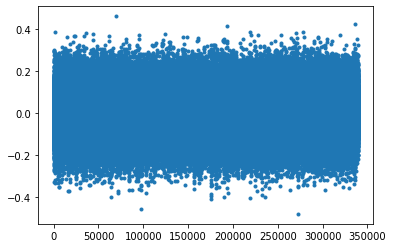

In [11]:
coh_syms = -np.exp(-1j*2*np.pi/16)*(recv_symbols[b:][:glfsr_diff.size] * np.conjugate(glfsr_diff))[10000:]
coh = np.angle(coh_syms)
plt.plot(coh, '.')

In [12]:
np.average(np.abs(coh) >= 2*np.pi/16)

3.534349458802739e-05

In [13]:
costas_syms = recv_symbols[b:][:glfsr_diff.size][10000:]
diff_syms = recv_symbols_diff[sel.start//3:sel.stop//3]

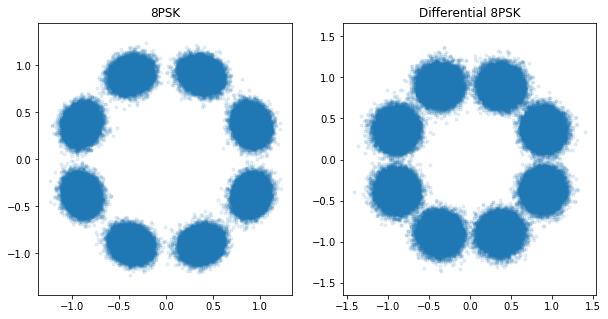

In [14]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].plot(costas_syms.real, costas_syms.imag, '.', alpha = 0.1)
axs[1].plot(diff_syms.real, diff_syms.imag, '.', alpha = 0.1)
for a in axs:
    a.axis('equal')
axs[0].set_title('8PSK')
axs[1].set_title('Differential 8PSK');

In [15]:
# MER for non differential
err = np.abs(coh_syms-1)
P_signal = 1
P_error = np.average(np.abs(err)**2)
10 * np.log10(P_signal/P_error)

18.658023249199374

In [16]:
# MER for differential
def mer_dB(x):
    constellation = np.exp(2*np.pi*1j*(np.arange(8) + 0.5)/8)
    data = constellation[np.argmin(np.abs(x.reshape((-1,1)) - constellation.reshape((1,-1))), axis = 1)]
    err = np.abs(x-data)
    P_signal = 1
    P_error = np.average(np.abs(err)**2)
    return 10 * np.log10(P_signal/P_error)

mer_dB(diff_syms)

16.573676495164197

In [17]:
fs = 8000
file = 'ota_recordings/20191216_8dpsk.c64'
noise = np.fromfile(file, dtype = 'complex64', count = fs*3)
signal = np.fromfile(file, dtype = 'complex64', count = fs*10, offset = fs*4*8)

In [18]:
noise_pwr = np.average(np.abs(noise)**2)
signal_plus_noise_pwr = np.average(np.abs(signal)**2)

CN0 = 10*np.log10((signal_plus_noise_pwr - noise_pwr)/(noise_pwr)*fs)
CN0

53.99422410918797

In [19]:
EsN0 = CN0 - 10*np.log10(2000)
EsN0

20.983924152548155

Text(0.5, 0, 'Frequency (Hz)')

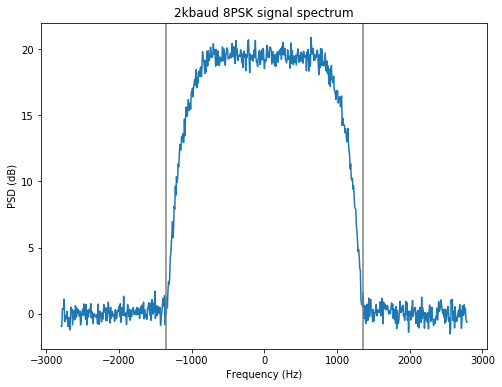

In [20]:
N = 2**10
spec = 10*np.log10(np.fft.fftshift(np.sum(np.abs(np.fft.fft(signal[:signal.size//N*N].reshape((-1,N))))**2, axis = 0)))
f = np.fft.fftshift(np.fft.fftfreq(N, 1/fs))
plt.figure(figsize = (8,6), facecolor = 'w')
span = int(N/fs*2800)
sel = slice(N//2-span,N//2+span)
norm = 10*np.log10(np.average(10**(spec[sel][0:int(N/fs*1000)]/10)))
plt.plot(f[sel], spec[sel]-norm)
plt.axvline(x = -2700/2, color = 'gray')
plt.axvline(x = 2700/2, color = 'gray')
plt.title('2kbaud 8PSK signal spectrum')
plt.ylabel('PSD (dB)')
plt.xlabel('Frequency (Hz)')